# Setup

## Imports

In [1]:
import QuantumOptics as qo
using Logging

using LinearAlgebra
using SparseArrays


import CairoMakie as cm

using ProtoStructs

import QuantumOptics.⊗
import QuantumOptics.*

import CSV
using JSON
import Tables

using YAXArrays
using DimensionalData

using MiniLoggers
using Dates
using Revise

In [2]:
import SuperconductingCavities as SC

[ Info: Precompiling SuperconductingCavities [ee3d56fb-bca2-435b-b019-382031bd701c]


## Extra Stuff

In [3]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(56) open, 0 bytes waiting))), Info, Logging.default_metafmt, true, 0, Dict{Any, Int64}())

In [4]:
function tostr(obj)
    io = IOBuffer()
    show(io, "text/plain", obj)
    String(take!(io))
end

tostr (generic function with 1 method)

# Doing Stuff

In [5]:
Mode3 = SC.Transmon_Resonators_Loader("ModelSaves/Mode_3/Mode_3.json");

In [6]:
Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]

Dict{String, Any} with 6 entries:
  "pulse_time"    => 177.8
  "Envelope Args" => Dict{String, Any}("pulse_time"=>177.8, "ramp_time"=>10)
  "epsilon"       => 0.88
  "Envelope"      => "Sine_Squared_Ramp"
  "shift"         => 0.0530359
  "freq_d"        => -2.87015

In [113]:
ε = 0.78#Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["epsilon"];
freq_d = Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["freq_d"];
println(freq_d)

stark_shifts = collect(LinRange(0.02, 0.08, 21));


-2.870147109080264


[2024-09-10 23:44:56] Info: Beginning Floquet Sweep
[2024-09-10 23:44:58] Info: Done With Floquet Sweep
[2024-09-10 23:44:58] Info: Tracking State (0, 1)
[2024-09-10 23:44:58] Info: Tracking State (2, 0)


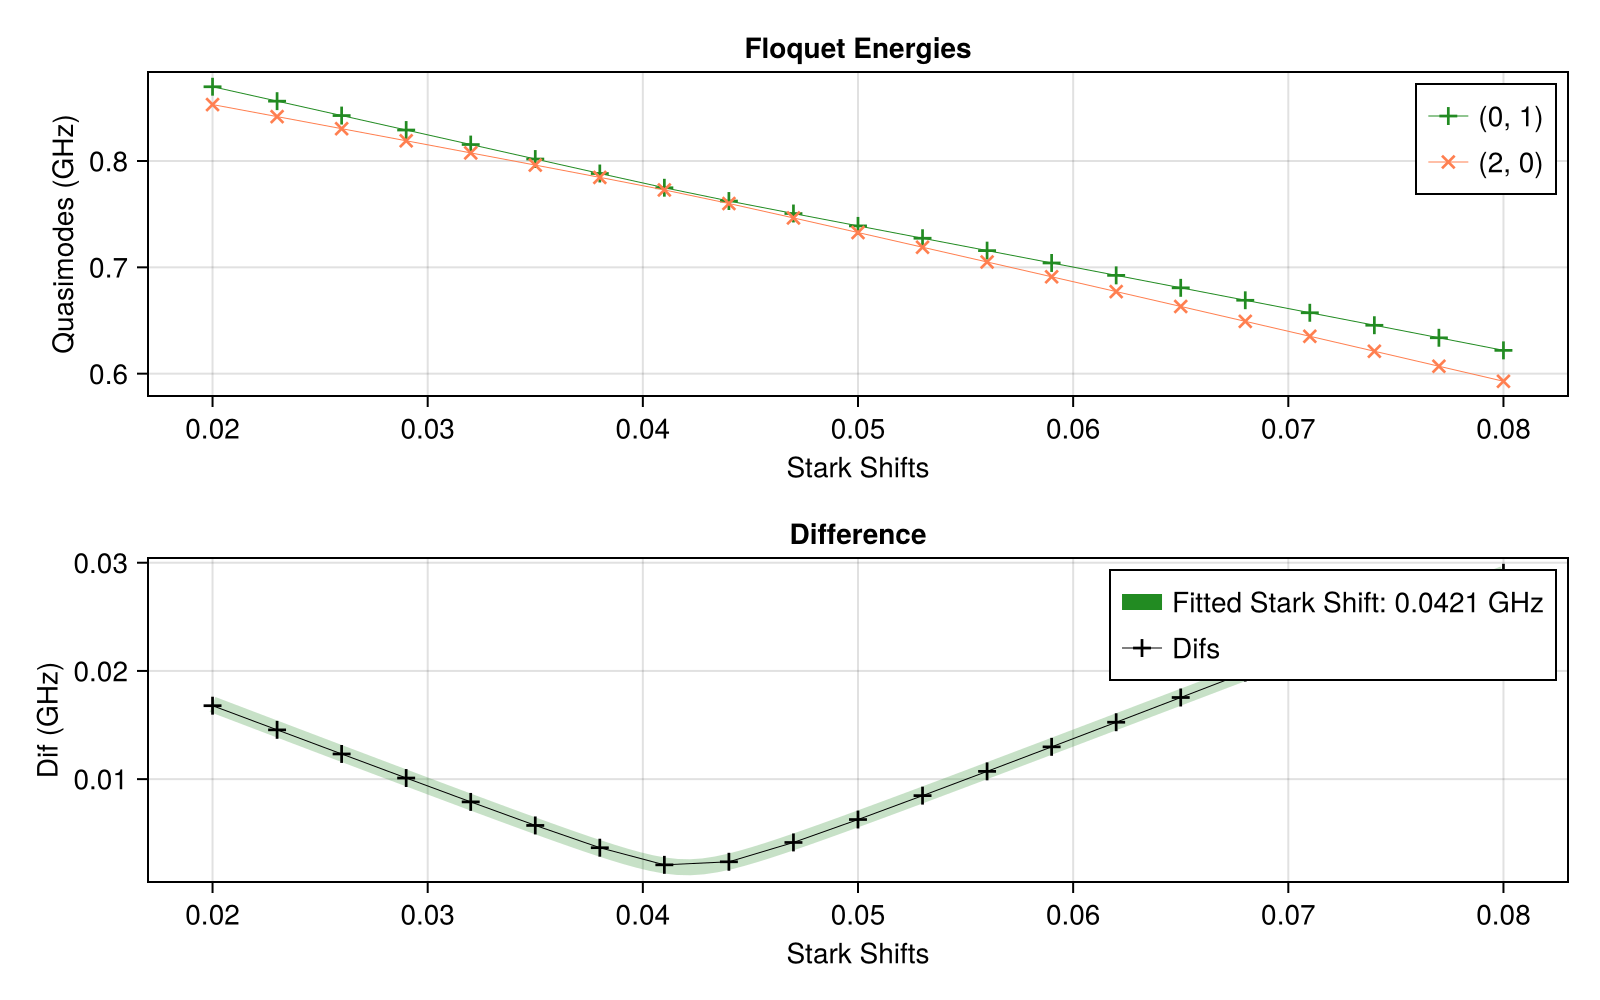

2-element Vector{Float64}:
   0.04205448989371391
 412.27827737824765

In [119]:
stark_shift_res = SC.FindStarkShift(Mode3, Mode3.n̂ₜ, (2,0), (0,1), ε, stark_shifts; make_plot = true, Floq_N_Steps = 50)

In [106]:
416.7815011846002

416.7815011846002

In [54]:
stark_shift_res[2][1]-stark_shift_res[1][1]

1.0130038232142475

In [50]:
1/0.32244913167107186

3.1012643601102736

In [79]:
min(3,2)

2

## Making Plots

In [8]:
dat = open_dataset("Data/Run_Loss_true_2024-09-03T14:34:45.280.nc")

YAXArray Dataset
Shared Axes: 
(↓ State Categorical{String} [(7, 1), (0, 3), …, (9, 0), (6, 7)] Unordered)
Variables: 
Step_1
  (↓ Step_1_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_8
  (↓ Step_8_Steps Sampled{Int64} 0:1:501 ForwardOrdered Regular Points)
Step_5
  (↓ Step_5_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_9
  (↓ Step_9_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_15
  (↓ Step_15_Steps Sampled{Int64} 0:1:501 ForwardOrdered Regular Points)
Step_17
  (↓ Step_17_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_11
  (↓ Step_11_Steps Sampled{Int64} 0:1:500 ForwardOrdered Regular Points)
Step_13
  (↓ Step_13_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_2
  (↓ Step_2_Steps Sampled{Int64} 0:1:501 ForwardOrdered Regular Points)
Step_10
  (↓ Step_10_Steps Sampled{Int64} 0:1:485 ForwardOrdered Regular Points)
Step_18
  (↓ Step_18_Steps Sampled{Int64} 0:1:4857 ForwardOrdered Regular Points)

In [9]:
dat.cubes[:Step_1]

╭─────────────────────────────╮
│ 100×359 YAXArray{Float64,2} │
├─────────────────────────────┴────────────────────────────────────────── dims ┐
  ↓ State        Categorical{String} [(7, 1), (0, 3), …, (9, 0), (6, 7)] Unordered,
  → Step_1_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Dict{String, Any} with 4 entries:
  "name"  => "Step_1"
  "Data"  => "Probabilities"
  "Times" => [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8  …  69.8, 70.0, …
  "Time"  => "2024-09-03T14:41:25.854"
├─────────────────────────────────────────────────────────────────── file size ┤ 
  file size: 280.47 KB
└──────────────────────────────────────────────────────────────────────────────┘

In [10]:
t0 = 0
times = []
ys = []
for i in 1:length(dat.cubes)
    @info "On Step $i"
    step_sym = Symbol("Step_$i")
    times = [times; t0 .+ dat.cubes[step_sym].properties["Times"]]
    t0 = times[end]
    push!(ys, collect(dat.cubes[step_sym].data))
end
ys = cat(ys...; dims = 2);

[2024-09-06 11:45:15] Info: On Step 1
[2024-09-06 11:45:17] Info: On Step 2
[2024-09-06 11:45:17] Info: On Step 3
[2024-09-06 11:45:17] Info: On Step 4
[2024-09-06 11:45:17] Info: On Step 5
[2024-09-06 11:45:17] Info: On Step 6
[2024-09-06 11:45:17] Info: On Step 7
[2024-09-06 11:45:17] Info: On Step 8
[2024-09-06 11:45:17] Info: On Step 9
[2024-09-06 11:45:17] Info: On Step 10
[2024-09-06 11:45:17] Info: On Step 11
[2024-09-06 11:45:17] Info: On Step 12
[2024-09-06 11:45:17] Info: On Step 13
[2024-09-06 11:45:17] Info: On Step 14
[2024-09-06 11:45:17] Info: On Step 15
[2024-09-06 11:45:17] Info: On Step 16
[2024-09-06 11:45:17] Info: On Step 17
[2024-09-06 11:45:17] Info: On Step 18


In [11]:
markers = ['+', '×', '∘', '⋆', '▿', '▵', '⊲', '⊳', '⏣', '⭔']

10-element Vector{Char}:
 '+': ASCII/Unicode U+002B (category Sm: Symbol, math)
 '×': Unicode U+00D7 (category Sm: Symbol, math)
 '∘': Unicode U+2218 (category Sm: Symbol, math)
 '⋆': Unicode U+22C6 (category Sm: Symbol, math)
 '▿': Unicode U+25BF (category So: Symbol, other)
 '▵': Unicode U+25B5 (category So: Symbol, other)
 '⊲': Unicode U+22B2 (category Sm: Symbol, math)
 '⊳': Unicode U+22B3 (category Sm: Symbol, math)
 '⏣': Unicode U+23E3 (category So: Symbol, other)
 '⭔': Unicode U+2B54 (category So: Symbol, other)

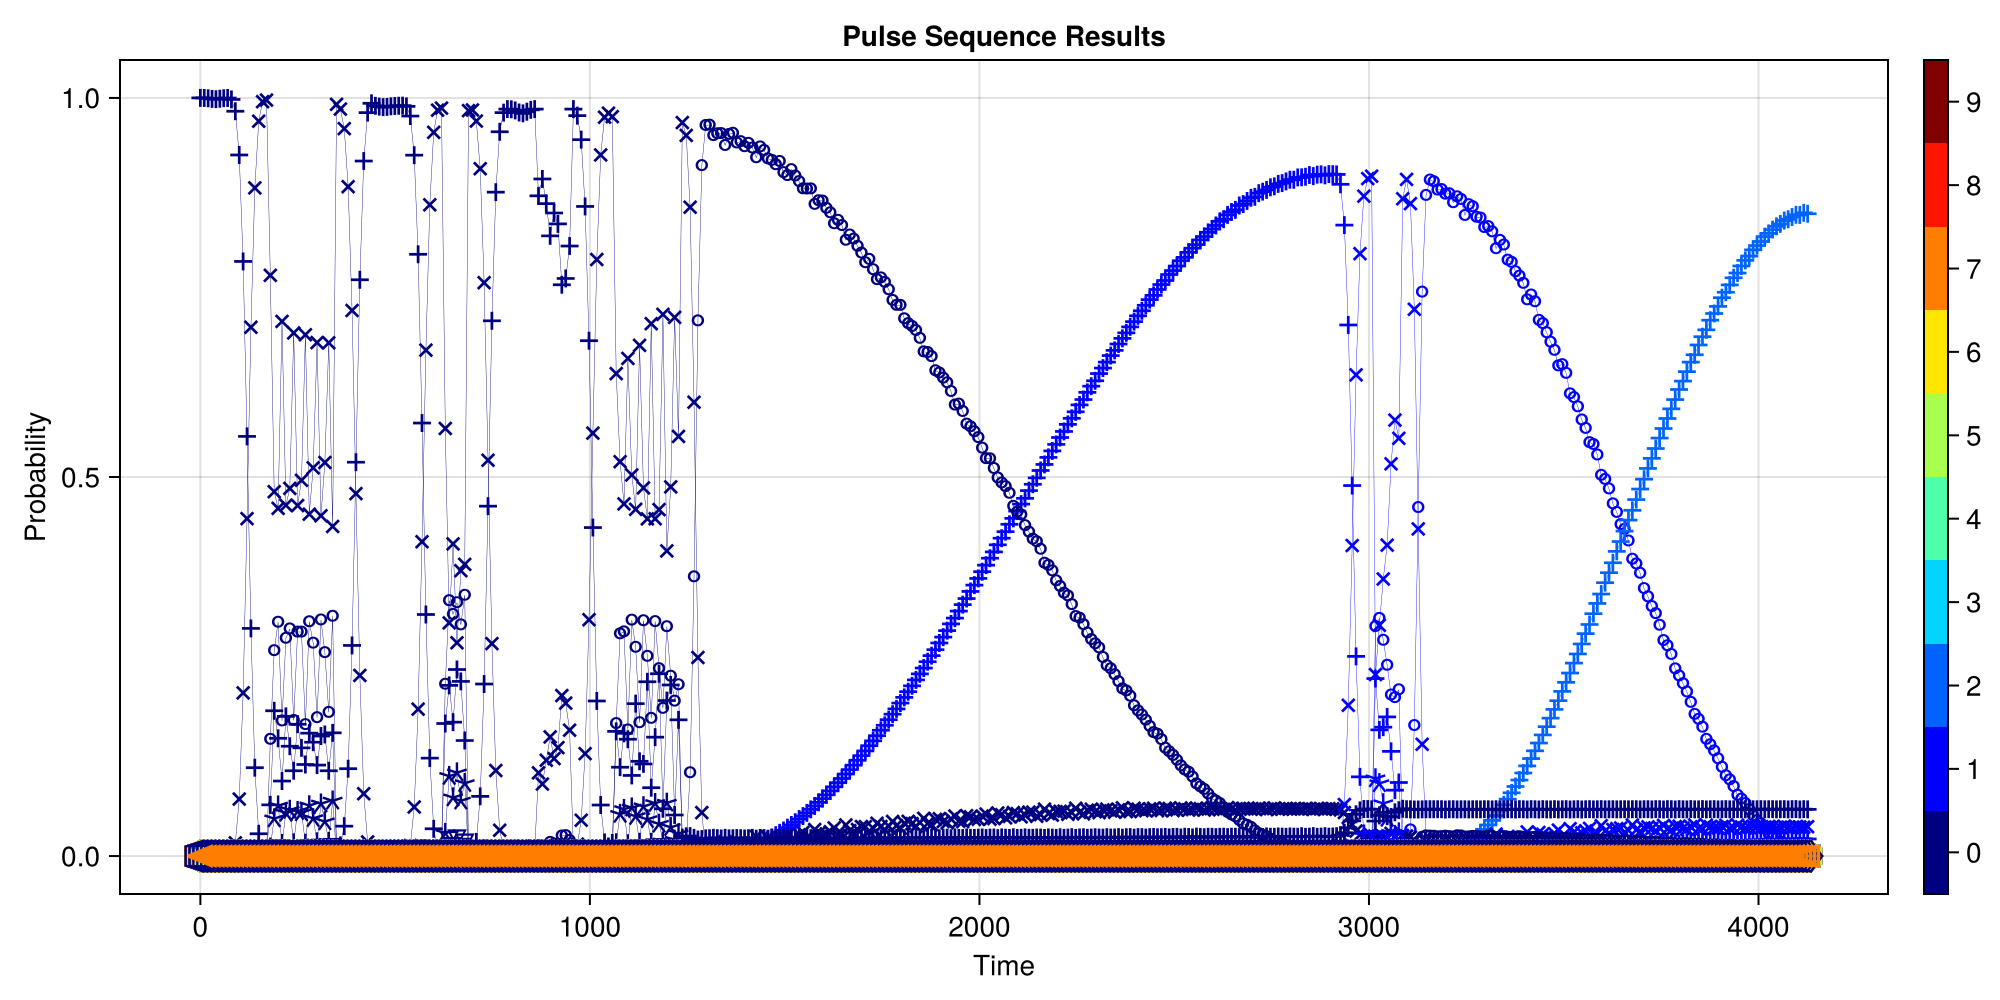

In [12]:
f = cm.Figure(size = (1000, 500), figure_padding = 10, px_per_unit = 4)

plot_every = 50

ax = cm.Axis(f[1,1], title = "Pulse Sequence Results", xlabel = "Time", ylabel = "Probability")

tlevels = qo.basis(Mode3.Ĥ).shape[1]
cmap=(cm.cgrad(:jet1, tlevels, categorical = true))

states = dat.cubes[:Step_1].axes[1]
for i in 1:length(states)
    t = eval(Meta.parse(states[i]))[1]
    c = eval(Meta.parse(states[i]))[2]
    x = times[1:plot_every:end]
    y = ys[i, :][1:plot_every:end]
    cm.scatterlines!(ax, x, y, marker = markers[t+1], label = states[i], color = cmap[c+1], markersize = 20, linewidth = 0.2)
end

tick_loc = collect(0:tlevels-1).+0.5
tick_name = string.(collect(0:tlevels-1))
cm.Colorbar(f[1,2], colormap = cmap, limits = (0,10), ticks = (tick_loc, tick_name))

f
